## Fit execution time

This is connected to FLIP [#753](https://github.com/onflow/flow/pull/753)

`execution_effort/execution_time` should (on average) be a constant that only depends on the machine running the transactions, and not the transactions themselves.

We can set `execution_effort/execution_time=1` for the calibration machine.

the collected data has the first column as the transaction identifier (the transaction type) and the last column as the actual execution time in ms. The other columns are features.

In [75]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import pearsonr
from sklearn import linear_model
from sklearn import model_selection
import statsmodels.api as sm
import seaborn as sns


In [112]:
data = pd.read_csv("data_c.csv")
data.describe()


,TransferCompositeValue,GetCode,GetAccountAvailableBalance,GetValue,GetStorageUsed,RLPDecoding,AllocateStorageIndex,DestroyCompositeValue,TransferArrayValue,GetCurrentBlockHeight,...,TransferDictionaryValue,FunctionInvocation,ResolveLocation,GetOrLoadProgram,SetValue,CreateDictionaryValue,GenerateUUID,Loop,estimated,ms
count,4770.000000,4770.000000,4770.000000,4.770000e+03,4770.000000,4770.000000,4770.000000,4770.000000,4.770000e+03,4770.0,...,4770.0,4770.000000,4770.000000,4770.000000,4.770000e+03,4770.0,4770.000000,4770.000000,4.770000e+03,4770.000000
mean,1649.275052,71.622013,55.456184,6.673661e+05,325.123061,7505.830398,522.954088,364.619916,7.872050e+04,0.0,...,0.0,14479.305451,40.839413,1684.916771,7.493172e+04,0.0,581.172746,12454.821174,6.186986e+04,173.434382
std,4539.187599,131.853766,268.556548,1.527873e+06,1541.023882,35787.537768,1634.490958,1378.045962,1.649396e+05,0.0,...,0.0,17808.300158,12.299002,4357.840126,2.555470e+05,0.0,1747.360784,23607.154364,8.188553e+04,509.796108
min,0.000000,37.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0,...,0.0,0.000000,35.000000,44.000000,0.000000e+00,0.0,0.000000,0.000000,8.600000e+01,0.000000
25%,0.000000,37.000000,0.000000,2.210000e+02,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0,...,0.0,4073.500000,35.000000,44.000000,0.000000e+00,0.0,0.000000,2282.000000,1.626000e+04,27.000000
50%,0.000000,37.000000,0.000000,1.913000e+03,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0,...,0.0,10081.500000,35.000000,44.000000,0.000000e+00,0.0,0.000000,6432.500000,3.859400e+04,87.000000
75%,0.000000,37.000000,0.000000,3.632098e+05,0.000000,0.000000,0.000000,0.000000,6.860000e+04,0.0,...,0.0,19639.000000,35.000000,74.000000,1.608000e+03,0.0,0.000000,14098.750000,7.716700e+04,212.750000
max,38588.000000,970.000000,2457.000000,1.125227e+07,28346.000000,312903.000000,16476.000000,13271.000000,1.351544e+06,0.0,...,0.0,500201.000000,69.000000,30739.000000,2.640836e+06,0.0,13935.000000,571966.000000,1.610205e+06,21848.000000


outliers 315


(array([1756.,  716.,  508.,  417.,  355.,  210.,  191.,  137.,  101.,
          64.]),
 array([  3. ,  52.6, 102.2, 151.8, 201.4, 251. , 300.6, 350.2, 399.8,
        449.4, 499. ]),
 <BarContainer object of 10 artists>)

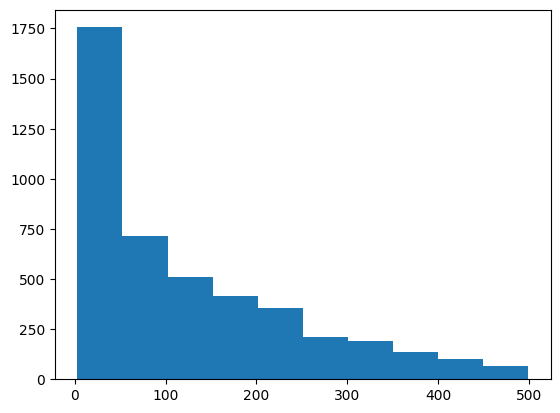

In [113]:
# remove outliers
outlier_idx = data.index[(data.ms > 500) | (data.ms < 3)]
print("outliers", len(outlier_idx))
data = data.drop(outlier_idx)

# remove estimated
data = data.drop(['estimated'], axis=1)

data['function_or_loop_call']=data['Loop'] +data['Statement'] +data['FunctionInvocation']

data = data.drop(['Loop','Statement','FunctionInvocation'], axis=1)

plt.hist(data.ms)

In [114]:
model_features = [
    "function_or_loop_call",
    "GetValue",
    "SetValue",
    "CreateAccount",
    "EVMGasUsage",
    #"RLPDecoding",
];

In [115]:
corr = data[
    model_features
].corr('pearson')
corr

,function_or_loop_call,GetValue,SetValue,CreateAccount,EVMGasUsage
function_or_loop_call,1.000000,-0.046852,0.067054,-0.127687,-0.045148
GetValue,-0.046852,1.000000,-0.027597,0.007114,0.024770
SetValue,0.067054,-0.027597,1.000000,-0.019345,0.427995
CreateAccount,-0.127687,0.007114,-0.019345,1.000000,-0.045154
EVMGasUsage,-0.045148,0.024770,0.427995,-0.045154,1.000000


<Axes: >

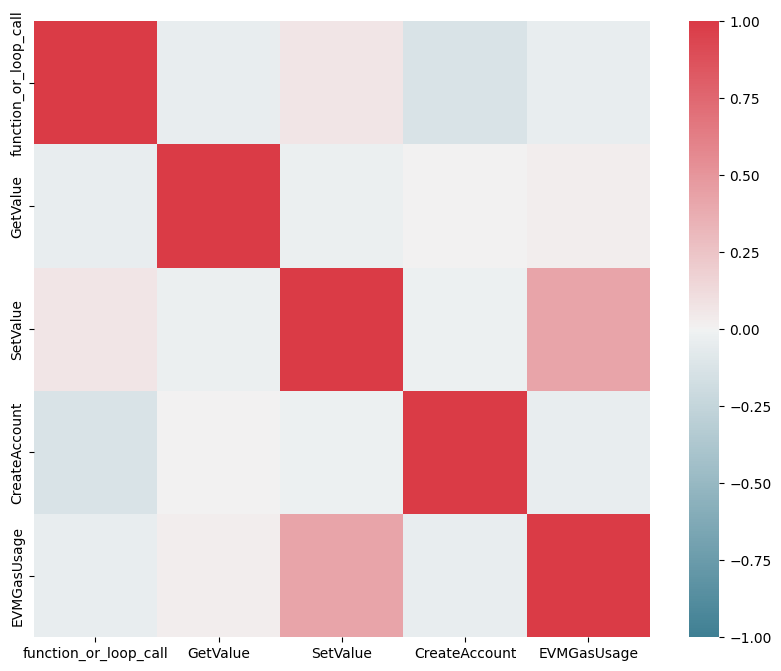

In [116]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr,
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            vmin=-1.0, vmax=1.0,
            square=True, ax=ax)


### Define features

# Linear model v0

In [117]:
selected_features = model_features
X_train, X_test, y_train, y_test = model_selection.train_test_split(data[selected_features], data.ms,
                                                                   test_size=0.2)

clf = linear_model.LinearRegression()
clf.fit(X_train[selected_features], y_train)

LinearRegression()

Text(0.5, 1.0, 'Model 1 R2:0.6892828397407801')

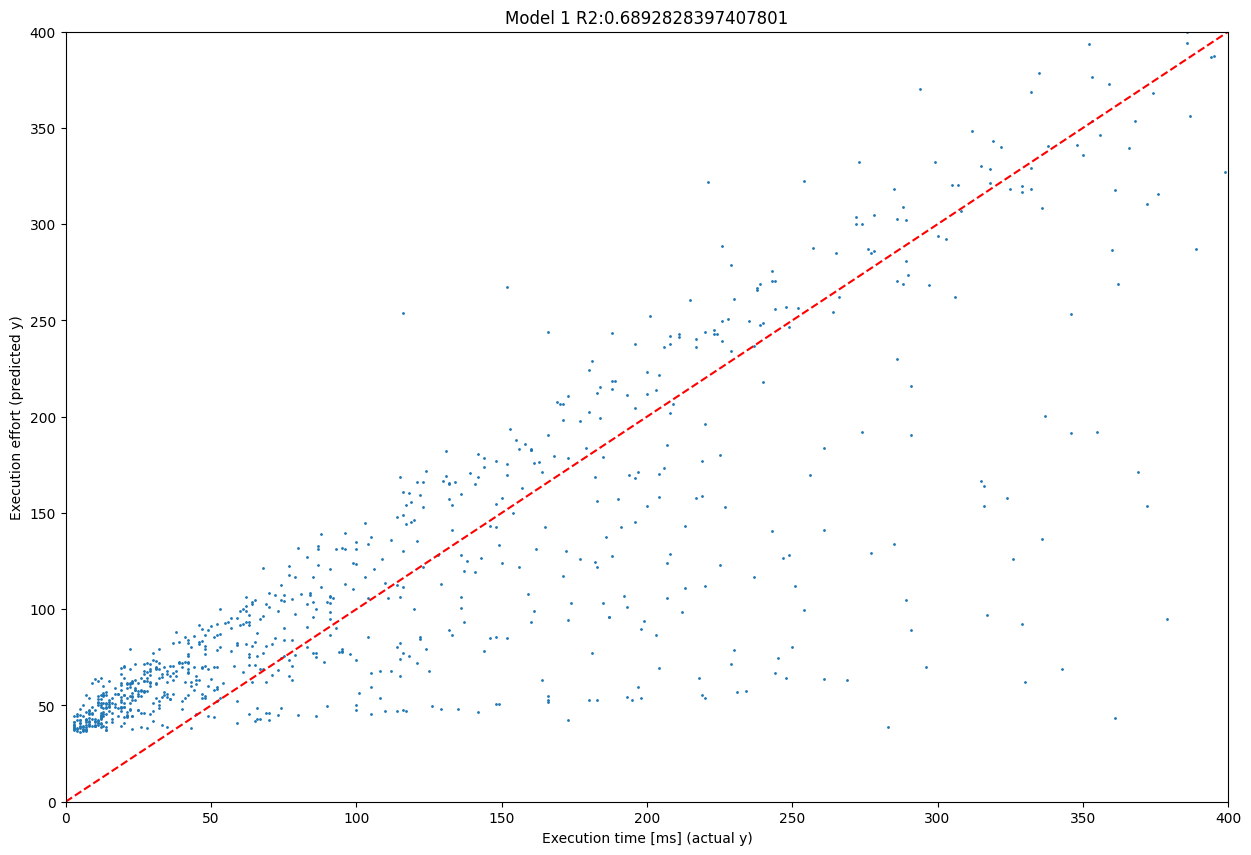

In [118]:
# plt.scatter(y_test,clf.predict(X_test))


diag = np.arange(0., 700., 10.)

fig, ax = plt.subplots(figsize=(15, 10))
ax.set(xlim=(0, 400), ylim=(0, 400))
ax.set_xlabel('Execution time [ms] (actual y)')
ax.set_ylabel('Execution effort (predicted y)')
plt.scatter(y_test, clf.predict(X_test[selected_features]), s=1)
plt.plot(diag, diag, 'r--')
plt.title("Model 1 R2:" + str(clf.score(X_test[selected_features], y_test)))

In [119]:
coefficients = {a: b for a, b in zip(clf.feature_names_in_, clf.coef_) if b != 0}
coefficients

{'function_or_loop_call': 0.0005434377908182418,
 'GetValue': 4.233703657815569e-05,
 'SetValue': 6.931759014514122e-05,
 'CreateAccount': 0.3520825599244242,
 'EVMGasUsage': 3.834779412508516e-06}

# Linear model v1


In [410]:
# selected_features=['function_or_loop_call','GetValue','ValueDecoded','ProgramInterpreted','GetProgram']
# selected_features=data.columns[1:-1]
selected_features = [k for k, v in corr_out.items() if v > 0.07]

In [411]:
# X_train, X_test, y_train, y_test=model_selection.train_test_split(data.loc[:,selected_features],data.ms,test_size=0.2)

In [412]:
clf = linear_model.Lasso(alpha=1, positive=True
                         )
clf.fit(X_train[selected_features], y_train)

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.727e+09, tolerance: 2.496e+06
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=1, positive=True)

In [413]:
print(clf.coef_)

[2.48436231e-02 0.00000000e+00 3.83496598e-01 7.64465925e-03
 1.94847619e-02 2.71925224e-02 2.31896142e-02 1.66591728e-01
 8.15117100e-14 4.59805368e-02 0.00000000e+00 3.64011048e-02
 1.10902934e-04 0.00000000e+00 0.00000000e+00 4.71357644e-04]


In [414]:
# print("train r2:" + str(clf.score(X_train[selected_features],y_train)))
# print("test r2:" + str(clf.score(X_test[selected_features],y_test)))

In [415]:
# print("train corr:" + str(pearsonr(clf.predict(X_train[selected_features]),y_train)[0]))
# print("test corr:" + str(pearsonr(clf.predict(X_test[selected_features]),y_test)[0]))

Text(0.5, 1.0, 'Model 1 R2:0.15846372567249256')

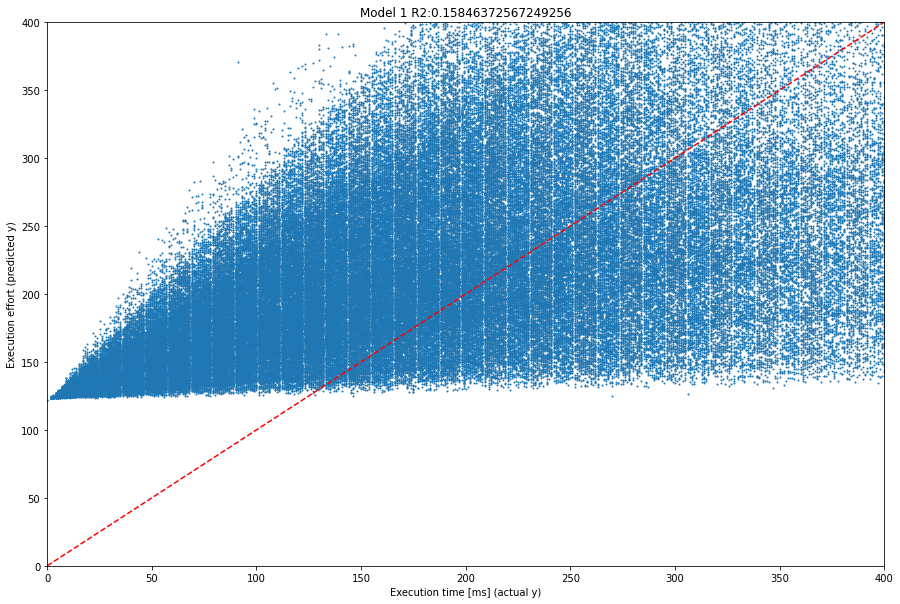

In [416]:
# plt.scatter(y_test,clf.predict(X_test))


diag = np.arange(0., 700., 10.)

fig, ax = plt.subplots(figsize=(15, 10))
ax.set(xlim=(0, 400), ylim=(0, 400))
ax.set_xlabel('Execution time [ms] (actual y)')
ax.set_ylabel('Execution effort (predicted y)')
plt.scatter(y_test, clf.predict(X_test[selected_features]), s=1)
plt.plot(diag, diag, 'r--')
plt.title("Model 1 R2:" + str(clf.score(X_test[selected_features], y_test)))

# Linear Model v2

In [417]:
# selected_features=data.columns[1:-1]
selected_features = [k for k, v in corr_out.items() if v > 0.07]
# X_train, X_test, y_train, y_test=model_selection.train_test_split(data_no_outlier.loc[:,selected_features],data_no_outlier.ms,test_size=0.2)

In [418]:
clf = linear_model.Lasso(alpha=1, \
                         positive=True
                         )

clf.fit(X_train2[selected_features], y_train2)

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.526e+08, tolerance: 8.243e+05
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=1, positive=True)

In [419]:
print(clf.coef_)

[1.48866684e-02 0.00000000e+00 4.08388535e-01 4.71402841e-03
 1.73220081e-02 1.73218938e-02 5.24451701e-02 9.55734927e-02
 0.00000000e+00 1.77790644e-02 0.00000000e+00 1.58233375e-02
 1.01473150e-04 0.00000000e+00 0.00000000e+00 3.86314847e-04]


In [420]:
# print("train r2:" + str(clf.score(X_train,y_train2)))
# print("test r2:" + str(clf.score(X_test,y_test2)))

In [421]:
# print("train corr:" + str(pearsonr(clf.predict(X_train),y_train)[0]))
# print("test corr:" + str(pearsonr(clf.predict(X_test),y_test)[0]))

Text(0.5, 1.0, 'Model 2 R2:0.25082133840764953')

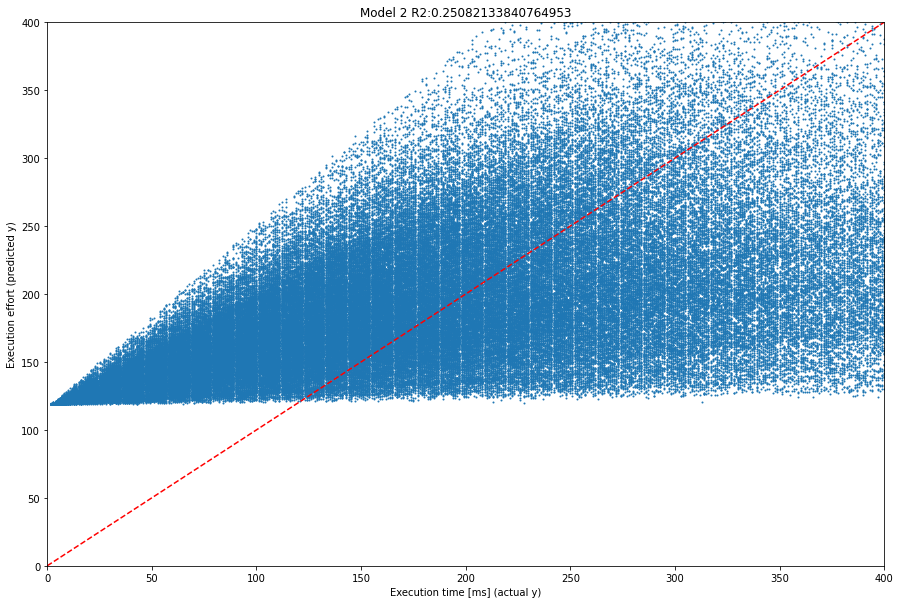

In [422]:
# plt.scatter(y_test,clf.predict(X_test))

diag = np.arange(0., 700., 10.)

fig, ax = plt.subplots(figsize=(15, 10))
ax.set(xlim=(0, 400), ylim=(0, 400))
ax.set_xlabel('Execution time [ms] (actual y)')
ax.set_ylabel('Execution effort (predicted y)')
plt.scatter(y_test2, clf.predict(X_test2[selected_features]), s=1)
plt.plot(diag, diag, 'r--')
plt.title("Model 2 R2:" + str(clf.score(X_test2[selected_features], y_test2)))

# Linear model 3

In [423]:
features = []
for i in range(len(selected_features)):
    if (clf.coef_ != 0)[i]:
        features.append(selected_features[i])
features.remove('GetAccountBalance')
features.remove('GetProgram')
features.remove('GetAccountAvailableBalance')


In [424]:
# X2=sm.add_constant(X_train[features])
est = sm.OLS(y_train, X2)
est2 = est.fit()
print(est2.summary())

NameError: name 'X2' is not defined

In [ ]:
X2_test = sm.add_constant(X_test2[features])
# plt.scatter(est2.predict(X2_test),y_test)
diag = np.arange(0., 700., 10.)

fig, ax = plt.subplots(figsize=(15, 10))
ax.set(xlim=(0, 400), ylim=(0, 400))
ax.set_xlabel('Execution time [ms] (actual y)')
ax.set_ylabel('Execution effort (predicted y)')
plt.scatter(y_test2, est2.predict(X2_test), s=1)
plt.plot(diag, diag, 'r--')
plt.title("Model 3 R2:" + str(pearsonr(est2.predict(X2_test), y_test2)[0] ** 2))

In [ ]:
pearsonr(est2.predict(X2_test), y_test)

In [ ]:
print("r2:" + str(0.5796279307474588 ** 2))

In [ ]:
features

# Linear model 4 

In [ ]:
# selected_features=data.columns[1:-1]
selected_features = ['AddEncodedAccountKey',
                     'ContractFunctionInvoke',
                     'CreateAccount',
                     'EmitEvent',
                     'GenerateUUID',
                     'GetAccountContractCode',
                     'GetCode',
                     'GetStorageUsed',
                     'RevokeEncodedAccountKey',
                     'ValueDecoded',
                     'function_or_loop_call']
# X_train, X_test, y_train, y_test=model_selection.train_test_split(data_no_outlier.loc[:,selected_features],data_no_outlier.ms,test_size=0.2)

In [ ]:
clf = linear_model.LinearRegression(
    positive=True
)
clf.fit(X_train2[selected_features], y_train2)

In [ ]:
print(clf.coef_)

In [ ]:
# print("train r2:" + str(clf.score(X_train2[selected_features],y_train)))
# print("test r2:" + str(clf.score(X_test2[selected_features],y_test)))

In [ ]:
# plt.scatter(est2.predict(X2_test),y_test)
diag = np.arange(0., 700., 10.)

fig, ax = plt.subplots(figsize=(15, 10))
ax.set(xlim=(0, 400), ylim=(0, 400))
ax.set_xlabel('Execution time [ms] (actual y)')
ax.set_ylabel('Execution effort (predicted y)')
plt.scatter(y_test2, clf.predict(X_test2[selected_features]), s=1)
plt.plot(diag, diag, 'r--')
plt.title("Model 3 R2:" + str(clf.score(X_test2[selected_features], y_test2)))

# Linear Model v5

In [ ]:
selected_features = list(X_train)
# selected_features.remove('ms')
# selected_features.remove('tx')

# X_train, X_test, y_train, y_test=model_selection.train_test_split(data.loc[:,selected_features],data.ms,test_size=0.2)
# X_train2=X_train[selected_features]
# X_test2=X_test[selected_features]
clf = linear_model.Lasso(alpha=0.1, \
                         positive=True
                         )

clf.fit(X_train, y_train)

In [ ]:
print(clf.coef_)

In [ ]:
# plt.scatter(est2.predict(X2_test),y_test)
diag = np.arange(0., 700., 10.)

fig, ax = plt.subplots(figsize=(15, 10))
ax.set(xlim=(0, 400), ylim=(0, 400))
ax.set_xlabel('Execution time [ms] (actual y)')
ax.set_ylabel('Execution effort (predicted y)')
plt.scatter(y_test, clf.predict(X_test), s=1)
plt.plot(diag, diag, 'r--')
plt.title("Model 3 R2:" + str(clf.score(X_test, y_test)))

# Linear Model v6 

In [ ]:
selected_features = list(X_train2)
# selected_features.remove('ms')
# selected_features.remove('tx')

# X_train, X_test, y_train, y_test=model_selection.train_test_split(data.loc[:,selected_features],data.ms,test_size=0.2)
# X_train2=X_train[selected_features]
# X_test2=X_test[selected_features]
clf2 = linear_model.Lasso(alpha=10, \
                          positive=True
                          )

clf2.fit(X_train2, y_train2)

In [ ]:
X_train2, X_test2, y_train2, y_test2

In [ ]:
print(clf.coef_)

In [ ]:
# plt.scatter(est2.predict(X2_test),y_test)
diag = np.arange(0., 700., 10.)

fig, ax = plt.subplots(figsize=(15, 10))
ax.set(xlim=(0, 400), ylim=(0, 400))
ax.set_xlabel('Execution time [ms] (actual y)')
ax.set_ylabel('Execution effort (predicted y)')
plt.scatter(y_test2, clf2.predict(X_test2), s=1)
plt.plot(diag, diag, 'r--')
plt.title("Model 3 R2:" + str(clf2.score(X_test2, y_test2)))

# Linear Model v7 - data3

In [392]:
selected_features = features
# X_train, X_test, y_train, y_test=model_selection.train_test_split(data.loc[:,selected_features],data.ms,test_size=0.2)
# X_train2=X_train[selected_features]
# X_test2=X_test[selected_features]
clf = linear_model.LinearRegression()
clf.fit(X_train3[selected_features], y_train3)

LinearRegression()

Text(0.5, 1.0, 'Model 1 R2:0.39235802475449777')

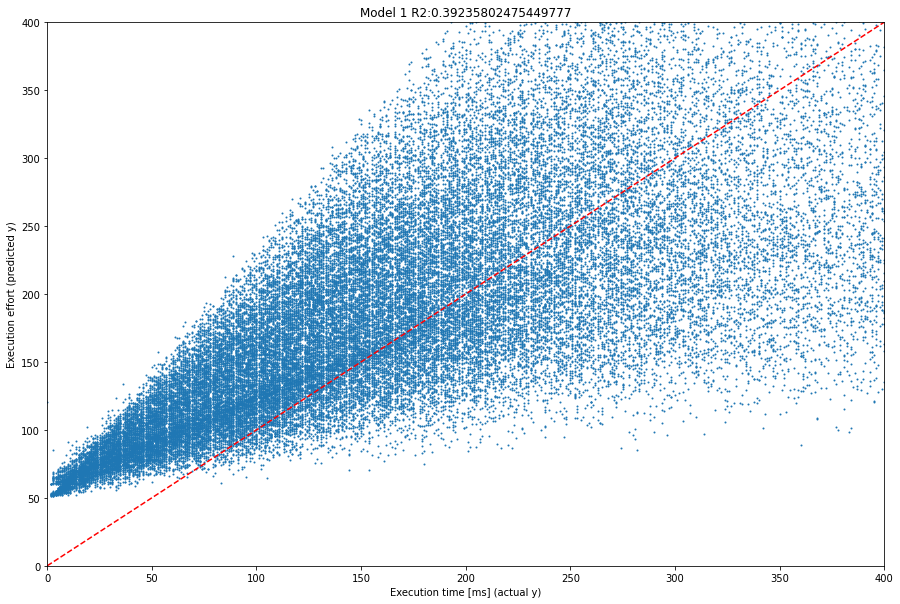

In [393]:
# plt.scatter(y_test,clf.predict(X_test))


diag = np.arange(0., 700., 10.)

fig, ax = plt.subplots(figsize=(15, 10))
ax.set(xlim=(0, 400), ylim=(0, 400))
ax.set_xlabel('Execution time [ms] (actual y)')
ax.set_ylabel('Execution effort (predicted y)')
plt.scatter(y_test3, clf.predict(X_test3[selected_features]), s=1)
plt.plot(diag, diag, 'r--')
plt.title("Model 1 R2:" + str(clf.score(X_test3[selected_features], y_test3)))

# Linear Model v8 - data4

In [394]:
selected_features = model_features
# X_train, X_test, y_train, y_test=model_selection.train_test_split(data.loc[:,selected_features],data.ms,test_size=0.2)
# X_train2=X_train[selected_features]
# X_test2=X_test[selected_features]
clf = linear_model.LinearRegression()
clf.fit(X_train4[selected_features], y_train4)

LinearRegression()

In [395]:
clf.coef_

array([ 4.96984268e-03, -6.37981654e-02, -1.27795168e+00,  1.09396333e+00,
        6.71060418e-02,  1.15671382e+00,  1.09396333e+00,  5.52250695e-04,
        1.88029892e-02,  3.15412229e-02,  7.25721904e-04, -2.29306321e+00,
        1.01137900e-01, -4.48151154e-04,  4.28978654e-02,  2.09640873e-02])

Text(0.5, 1.0, 'Model 1 R2:0.663365003768952')

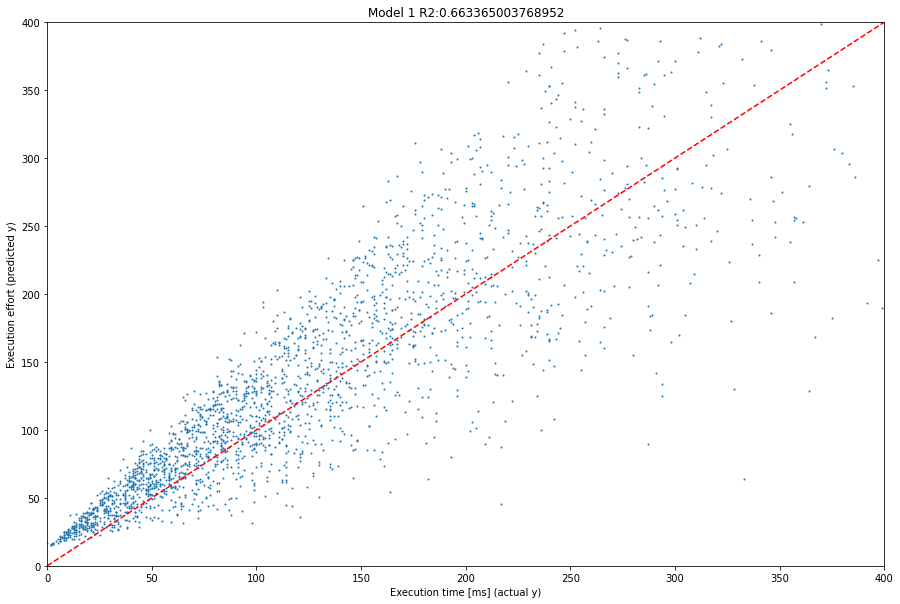

In [396]:
# plt.scatter(y_test,clf.predict(X_test))


diag = np.arange(0., 700., 10.)

fig, ax = plt.subplots(figsize=(15, 10))
ax.set(xlim=(0, 400), ylim=(0, 400))
ax.set_xlabel('Execution time [ms] (actual y)')
ax.set_ylabel('Execution effort (predicted y)')
plt.scatter(y_test4, clf.predict(X_test4[selected_features]), s=1)
plt.plot(diag, diag, 'r--')
plt.title("Model 1 R2:" + str(clf.score(X_test4[selected_features], y_test4)))

In [397]:
pearsonr(clf.predict(test[selected_features]), test.ms)

(0.44176847519141416, 0.0)

Text(0.5, 1.0, 'Model 1 R2:-6.549446871770838')

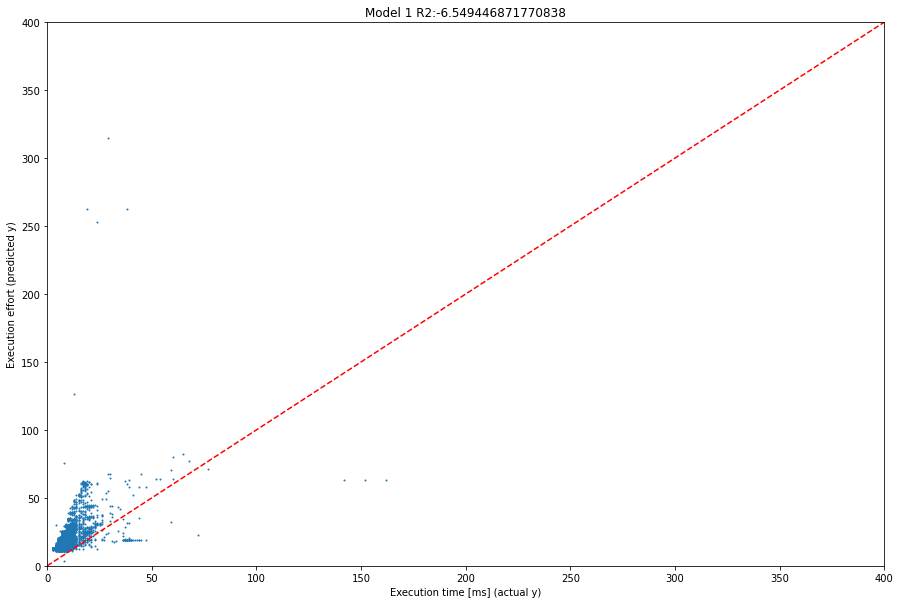

In [398]:
diag = np.arange(0., 700., 10.)

fig, ax = plt.subplots(figsize=(15, 10))
ax.set(xlim=(0, 400), ylim=(0, 400))
ax.set_xlabel('Execution time [ms] (actual y)')
ax.set_ylabel('Execution effort (predicted y)')
plt.scatter(test.ms, clf.predict(test[selected_features]), s=1)
plt.plot(diag, diag, 'r--')
plt.title("Model 1 R2:" + str(clf.score(test[selected_features], test.ms)))

# Linear Model v9 - data3_1

In [ ]:
selected_features = features
# X_train, X_test, y_train, y_test=model_selection.train_test_split(data.loc[:,selected_features],data.ms,test_size=0.2)
# X_train2=X_train[selected_features]
# X_test2=X_test[selected_features]
clf = linear_model.LinearRegression()
clf.fit(X_train31[selected_features], y_train31)

In [ ]:
# plt.scatter(y_test,clf.predict(X_test))


diag = np.arange(0., 700., 10.)

fig, ax = plt.subplots(figsize=(15, 10))
ax.set(xlim=(0, 400), ylim=(0, 400))
ax.set_xlabel('Execution time [ms] (actual y)')
ax.set_ylabel('Execution effort (predicted y)')
plt.scatter(y_test31, clf.predict(X_test31[selected_features]), s=1)
plt.plot(diag, diag, 'r--')
plt.title("Model 1 R2:" + str(clf.score(X_test31[selected_features], y_test31)))

# Linear Model v10 - data3_2

In [ ]:
selected_features = model_features
# X_train, X_test, y_train, y_test=model_selection.train_test_split(data.loc[:,selected_features],data.ms,test_size=0.2)
# X_train2=X_train[selected_features]
# X_test2=X_test[selected_features]
clf = linear_model.LinearRegression()
clf.fit(X_train32[selected_features], y_train32)

In [ ]:
# plt.scatter(y_test,clf.predict(X_test))


diag = np.arange(0., 700., 10.)

fig, ax = plt.subplots(figsize=(15, 10))
ax.set(xlim=(0, 400), ylim=(0, 400))
ax.set_xlabel('Execution time [ms] (actual y)')
ax.set_ylabel('Execution effort (predicted y)')
plt.scatter(y_test32, clf.predict(X_test32[selected_features]), s=1)
plt.plot(diag, diag, 'r--')
plt.title("Model 1 R2:" + str(clf.score(X_test32[selected_features], y_test32)))

In [ ]:
pearsonr(clf.predict(test[selected_features]), test.ms)

In [ ]:
diag = np.arange(0., 700., 10.)

fig, ax = plt.subplots(figsize=(15, 10))
ax.set(xlim=(0, 50), ylim=(0, 50))
ax.set_xlabel('Execution time [ms] (actual y)')
ax.set_ylabel('Execution effort (predicted y)')
plt.scatter(test.ms, clf.predict(test[selected_features]), s=1)
plt.plot(diag, diag, 'r--')
plt.title("Model 1 R2:" + str(clf.score(test[selected_features], test.ms)))

# Linear Model v11 - data4


In [ ]:
corr_out

In [399]:
selected_features = [k for k, v in corr_out.items() if v > 0.2 and k in model_features]

# clf=linear_model.Lasso(alpha=0.1,\
#                       positive=True
#                       )
clf = linear_model.LinearRegression()

clf.fit(X_train4[selected_features], y_train4)

LinearRegression()

In [400]:
clf.coef_

array([-1.25372643e+00,  1.18077877e+00,  1.06233225e-01,  1.10663278e+00,
        1.10663278e+00,  3.21272169e-02, -8.34497097e-02,  7.38237811e-04,
       -3.14085795e-04, -2.26027782e+00,  5.40173420e-04])

Text(0.5, 1.0, 'Model 1 R2:0.6552645981515506')

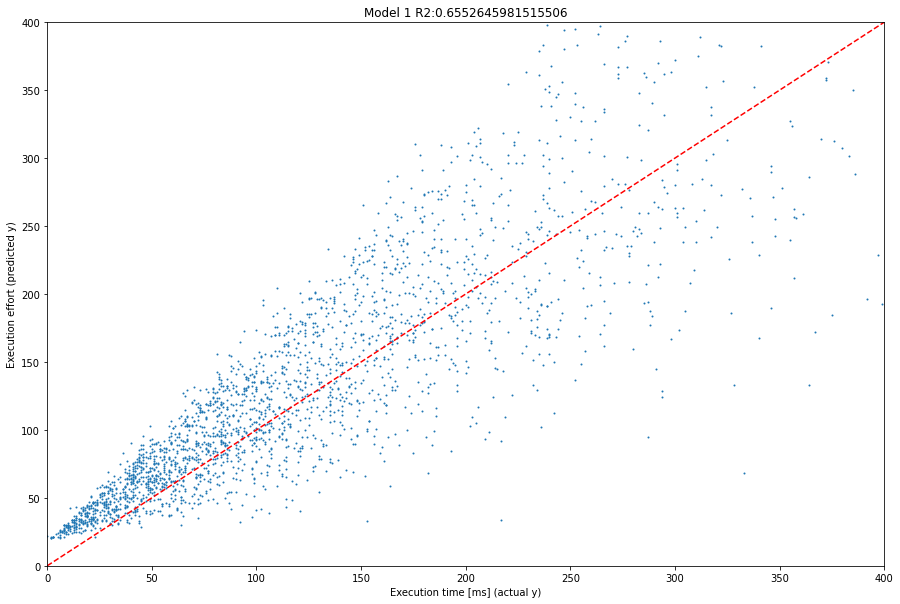

In [401]:
# plt.scatter(y_test,clf.predict(X_test))


diag = np.arange(0., 700., 10.)

fig, ax = plt.subplots(figsize=(15, 10))
ax.set(xlim=(0, 400), ylim=(0, 400))
ax.set_xlabel('Execution time [ms] (actual y)')
ax.set_ylabel('Execution effort (predicted y)')
plt.scatter(y_test4, clf.predict(X_test4[selected_features]), s=1)
plt.plot(diag, diag, 'r--')
plt.title("Model 1 R2:" + str(clf.score(X_test4[selected_features], y_test4)))

In [ ]:
pearsonr(clf.predict(test[selected_features]), test.ms)

In [ ]:
diag = np.arange(0., 700., 10.)

fig, ax = plt.subplots(figsize=(15, 10))
ax.set(xlim=(0, 50), ylim=(0, 50))
ax.set_xlabel('Execution time [ms] (actual y)')
ax.set_ylabel('Execution effort (predicted y)')
plt.scatter(test.ms, clf.predict(test[selected_features]), s=1)
plt.plot(diag, diag, 'r--')
plt.title("Model 1 R2:" + str(clf.score(test[selected_features], test.ms)))

# Linear Model v12

In [425]:
selected_features = model_features
# selected_features.remove('ms')
# selected_features.remove('tx')

# X_train, X_test, y_train, y_test=model_selection.train_test_split(data.loc[:,selected_features],data.ms,test_size=0.2)
# X_train2=X_train[selected_features]
# X_test2=X_test[selected_features]
clf = linear_model.Lasso(alpha=10, \
                         positive=True
                         )

clf.fit(X_train4[selected_features], y_train4)

Lasso(alpha=10, positive=True)

In [426]:
clf.coef_

array([6.24816012e-03, 0.00000000e+00, 0.00000000e+00, 5.06319402e-01,
       5.40969618e-02, 5.37348097e-01, 1.77978643e-04, 5.05728205e-04,
       1.87464688e-03, 0.00000000e+00, 1.20974881e-04, 0.00000000e+00,
       5.24549423e-02, 0.00000000e+00, 7.61121794e-02, 2.85053093e-02])

Text(0.5, 1.0, 'Model 1 R2:0.652364089322631')

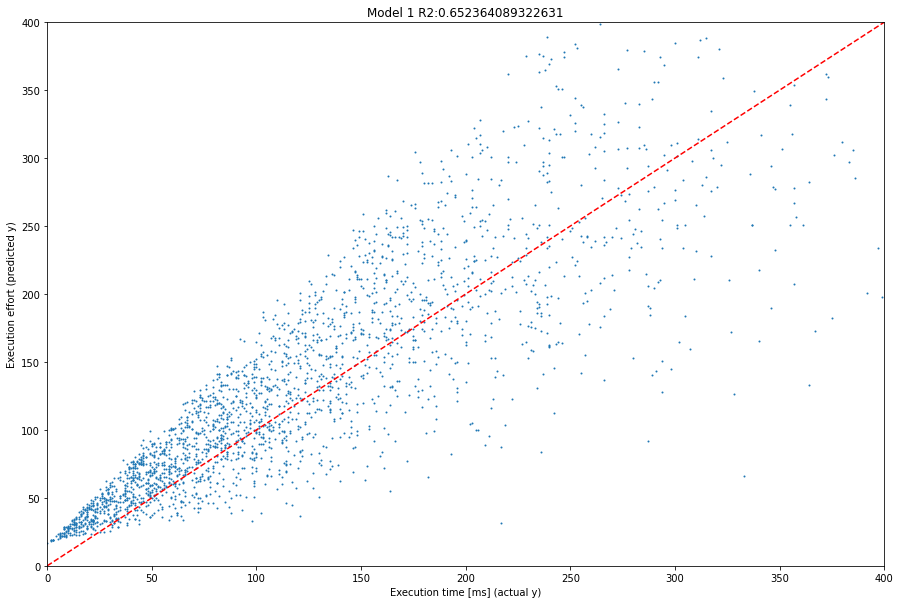

In [427]:
# plt.scatter(y_test,clf.predict(X_test))


diag = np.arange(0., 700., 10.)

fig, ax = plt.subplots(figsize=(15, 10))
ax.set(xlim=(0, 400), ylim=(0, 400))
ax.set_xlabel('Execution time [ms] (actual y)')
ax.set_ylabel('Execution effort (predicted y)')
plt.scatter(y_test4, clf.predict(X_test4[selected_features]), s=1)
plt.plot(diag, diag, 'r--')
plt.title("Model 1 R2:" + str(clf.score(X_test4[selected_features], y_test4)))

In [431]:
pearsonr(clf.predict(test[selected_features]), test.ms)[0] ** 2

0.28675260330561725

Text(0.5, 1.0, 'Model 1 R2:-4.7325250114276916')

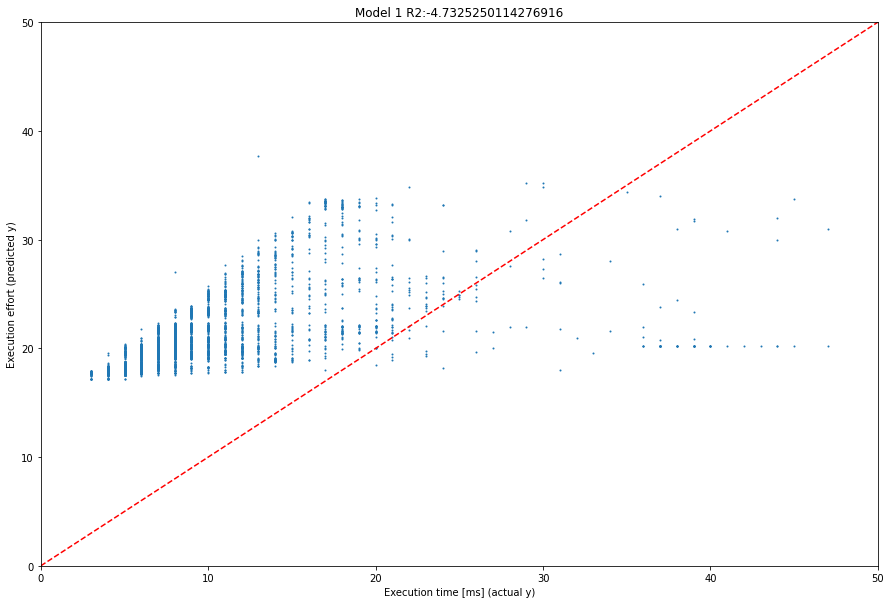

In [429]:
diag = np.arange(0., 700., 10.)

fig, ax = plt.subplots(figsize=(15, 10))
ax.set(xlim=(0, 50), ylim=(0, 50))
ax.set_xlabel('Execution time [ms] (actual y)')
ax.set_ylabel('Execution effort (predicted y)')
plt.scatter(test.ms, clf.predict(test[selected_features]), s=1)
plt.plot(diag, diag, 'r--')
plt.title("Model 1 R2:" + str(clf.score(test[selected_features], test.ms)))

# Linear Model v13 - data4

In [438]:
corr_out

{'AddEncodedAccountKey': 0.007774530487666141,
 'AllocateStorageIndex': 0.19660312118122314,
 'ContractFunctionInvoke': 0.5300798628830335,
 'CreateAccount': 0.3310986841154404,
 'EmitEvent': 0.14056645689890407,
 'GenerateUUID': 0.2414636219617315,
 'GetAccountAvailableBalance': 0.12590695892588544,
 'GetAccountBalance': 0.20552040216652911,
 'GetAccountContractCode': 0.2711064575626594,
 'GetCode': 0.2711064575626594,
 'GetProgram': 0.5376426397073721,
 'GetStorageCapacity': 0.3162285068557036,
 'GetStorageUsed': 0.11926435818881477,
 'GetValue': 0.5313066217403468,
 'RevokeEncodedAccountKey': -0.0009834142004465024,
 'SetValue': 0.20285820084561484,
 'UpdateAccountContractCode': 0.2690276403423267,
 'function_or_loop_call': 0.5273540679522408}

In [448]:
selected_features = [k for k, v in corr_out.items() if v > 0.2 and k in model_features]

# clf=linear_model.Lasso(alpha=0.1,\
#                       positive=True
#                       )

clf = linear_model.Lasso(alpha=10, \
                         positive=True
                         )

clf.fit(X_train4[selected_features], y_train4)

Lasso(alpha=10, positive=True)

In [449]:
clf.coef_

array([0.00000000e+00, 6.08858326e-01, 5.33034323e-02, 5.02175845e-01,
       3.06691889e-17, 7.16605702e-02, 0.00000000e+00, 1.33757484e-04,
       0.00000000e+00, 0.00000000e+00, 4.92205003e-04])

In [451]:
clf.feature_names_in_

array(['ContractFunctionInvoke', 'CreateAccount', 'GenerateUUID',
       'GetAccountContractCode', 'GetCode', 'GetProgram',
       'GetStorageCapacity', 'GetValue', 'SetValue',
       'UpdateAccountContractCode', 'function_or_loop_call'], dtype=object)

In [462]:
coefficients = {a: b for a, b in zip(clf.feature_names_in_, clf.coef_) if b != 0}
coefficients

{'CreateAccount': 0.6088583259288349,
 'GenerateUUID': 0.05330343232503861,
 'GetAccountContractCode': 0.502175844603492,
 'GetCode': 3.0669188939490816e-17,
 'GetProgram': 0.07166057015371416,
 'GetValue': 0.00013375748398192314,
 'function_or_loop_call': 0.0004922050026884043}

Text(0.5, 1.0, 'Model 1 R2:0.6453814454726806')

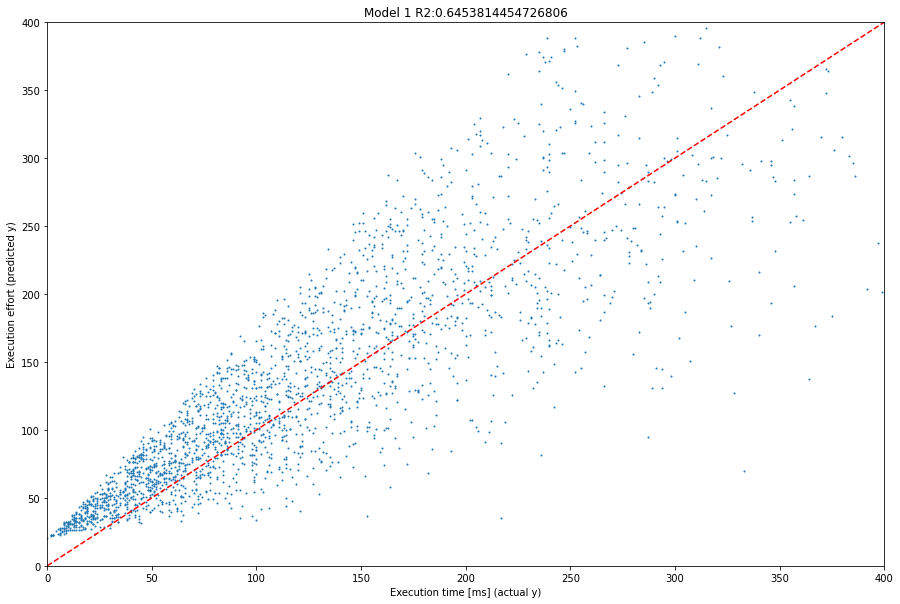

In [450]:
# plt.scatter(y_test,clf.predict(X_test))


diag = np.arange(0., 700., 10.)

fig, ax = plt.subplots(figsize=(15, 10))
ax.set(xlim=(0, 400), ylim=(0, 400))
ax.set_xlabel('Execution time [ms] (actual y)')
ax.set_ylabel('Execution effort (predicted y)')
plt.scatter(y_test4, clf.predict(X_test4[selected_features]), s=1)
plt.plot(diag, diag, 'r--')
plt.title("Model 1 R2:" + str(clf.score(X_test4[selected_features], y_test4)))

Text(0.5, 1.0, 'Model 1 R2:0.2729845168376481')

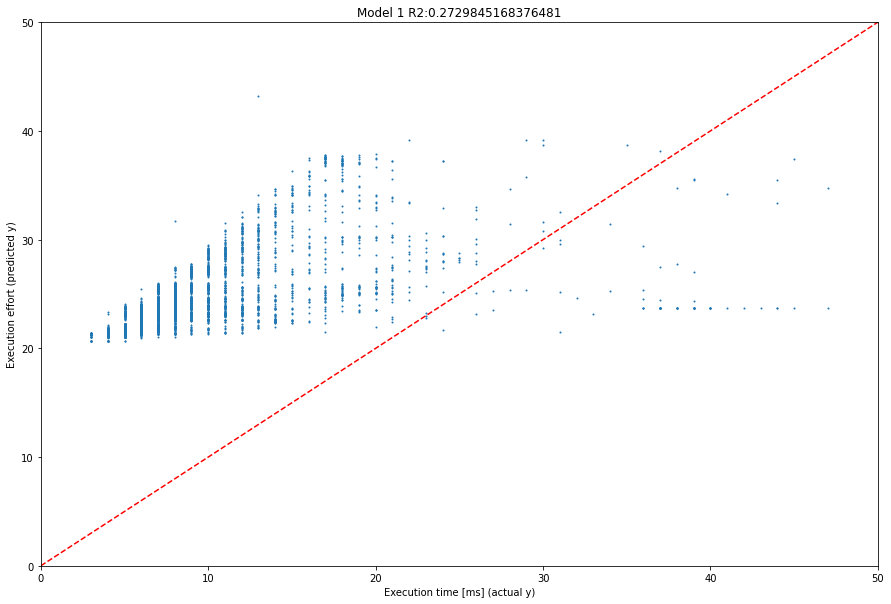

In [458]:
diag = np.arange(0., 700., 10.)

fig, ax = plt.subplots(figsize=(15, 10))
ax.set(xlim=(0, 50), ylim=(0, 50))
ax.set_xlabel('Execution time [ms] (actual y)')
ax.set_ylabel('Execution effort (predicted y)')
plt.scatter(test.ms, clf.predict(test[selected_features]), s=1)
plt.plot(diag, diag, 'r--')
plt.title("Model 1 R2:" + str(pearsonr(clf.predict(test[selected_features]), test.ms)[0] ** 2))

In [456]:
pearsonr(clf.predict(test[selected_features]), test.ms)[0] ** 2

0.2729845168376481

In [464]:
data4[coefficients.keys()].corr('pearson')

,CreateAccount,GenerateUUID,GetAccountContractCode,GetCode,GetProgram,GetValue,function_or_loop_call
CreateAccount,1.000000,-0.001390,0.708952,0.708952,0.270659,0.218319,0.079571
GenerateUUID,-0.001390,1.000000,0.025999,0.025999,-0.236753,-0.235585,0.085243
GetAccountContractCode,0.708952,0.025999,1.000000,1.000000,0.178805,0.194810,-0.008942
GetCode,0.708952,0.025999,1.000000,1.000000,0.178805,0.194810,-0.008942
GetProgram,0.270659,-0.236753,0.178805,0.178805,1.000000,0.953765,0.312535
GetValue,0.218319,-0.235585,0.194810,0.194810,0.953765,1.000000,0.303343
function_or_loop_call,0.079571,0.085243,-0.008942,-0.008942,0.312535,0.303343,1.000000


SetValue instead of GenerateUUID
GetValue instaed of GetProgram
dont keep ContractFunctionInvoke
keep createAccount

# Discussion


0. split data to train and test

0.1 exploratory data analysis

1. Does not start at the origin.

```
data quality. why some txn has quite different ms when all other features are similar? refer to univarite plot
missing variable or some data is wrong
```

In [ ]:
data.loc[data.ms <= 10].head(1)

2.Some features have negative weights. This is very unsafe, as it can be exploited.

```
the current data exhibit a negative relationship. we can force it though. can we keep negative weights?
```

3.Graph has lines where deta is denser, this is due to the properties of the error of execution time and the fact that there are transactions of different types.
```
missing variables or some data is wrong. some txn has much longer execution time
```

4. Overall it has data quality issue
- 4.1 need help to remove some outliers
- 4.2 can txn type be categorized to fewer groups , 577 now instead of 25. what are mixed transactions. can 3 mixed in reality?
- 4.2 need to get more data

- 4.3 what is the best source of data - mainet, testnet?

 

In [ ]:
data.shape

In [ ]:
100
k

In [ ]:
1.
100
k
raw
records
from testnet

2.
try to collect data from different nodes
3.
20
k
from mainnet as test

dataset
4.
help
identify
outliers
5.
insights
about
must and not -to - use
features - function_or_loop_call
